In [1]:
import sys
sys.path.append('..')

import utils, selex_dca, indep_sites
import adabmDCA
import selex_distribution, energy_models, tree, data_loading, training, callback, sampling
import diagnostic, specialized_models

import torch
from utils import one_hot
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import sklearn

/Users/scrotti/Aptamer2025py/experiments/../selex_dca.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
dtype = torch.float32

## Generate

In [313]:
tr = tree.Tree()
tr.add_node(-1, name = "round 1 with selection")
tr.add_node(0, name = "round 2 with selection")

selected_modes = torch.BoolTensor(
    [[1],
     [1]]
)

n_selection_rounds, n_modes = selected_modes.size()
assert n_selection_rounds == tr.get_n_nodes()
n_rounds = n_selection_rounds + 1

In [314]:
L, q = 10, 3

In [315]:
def hamming(x:torch.tensor, y: torch.tensor):
    L = x.size(-2)
    return L - (x * y).sum((-2, -1)).to(torch.int)

Pick as wildtype something which is well-aligned with ps

In [316]:
generator = torch.Generator().manual_seed(0)

h_teacher = torch.randn(L, q, dtype=dtype, generator=generator)

wt_oh = sampling.sample_indep_sites(h_teacher, n_samples=1, generator=generator, beta=7.0).squeeze()
torch.nn.functional.cosine_similarity(wt_oh, h_teacher.exp()).mean()

tensor(0.8363)

In [317]:
mutation_rate = 0.2
k_teacher = utils.field_from_wildtype(wt_oh, mutation_rate)

Ns0_teacher = energy_models.IndepSites(k_teacher)
ps_teacher = selex_distribution.MultiModeDistribution(energy_models.IndepSites(h_teacher), normalized=False)
model_teacher = selex_distribution.MultiRoundDistribution(Ns0_teacher, ps_teacher, tr, selected_modes)
model_teacher.train(mode=False);

In [318]:
n_chains = 10**5
chains_teacher = training.init_chains(n_rounds, n_chains, L, q, dtype=dtype)

In [319]:
n_sweeps = 50
energies = model_teacher.sample(chains_teacher, n_sweeps)

In [320]:
sequences_oh = chains_teacher
total_reads = total_reads = torch.Tensor([sequences_oh.shape[1] for _ in range(n_rounds)])

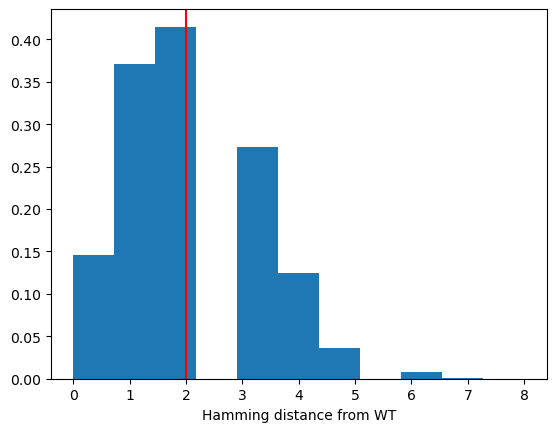

In [321]:
d = hamming(wt_oh, sequences_oh[0])
plt.hist(d, bins=L+1, density=True)
plt.axvline([mutation_rate * L], color='r', label='Nominal mutation rate')
plt.xlabel('Hamming distance from WT');

In [322]:
(d < 1).sum()

tensor(10614)

## Learn

In [312]:
# from importlib import reload
# reload(energy_models)
# reload(selex_distribution)
# reload(utils)
# reload(training)
# reload(callback)
# reload(specialized_models)

<module 'specialized_models' from '/Users/scrotti/Aptamer2025py/experiments/../specialized_models.py'>

In [323]:
k = torch.zeros(L, q, dtype=dtype)
h = torch.zeros(L, q, dtype=dtype)

model_indep = specialized_models.IndepSitesMultiRoundDistribution(k, h, n_rounds)

In [324]:
model_indep.cache_site_frequencies(sequences_oh)

In [325]:
data_loaders_indep = [data_loading.SelexRoundDataLoader(sequences_oh[id]) for id in range(n_rounds)]
chains_indep = chains = training.init_chains(n_rounds, 1, L, q)

In [326]:
callbacks_indep = [callback.ConvergenceMetricsCallback(), callback.TeacherStudentCallback(model_teacher)]

In [327]:
n_sweeps = 1
lr = 0.1
max_epochs = 1000

training.train(model_indep, data_loaders_indep, total_reads, chains_indep, n_sweeps, max_epochs, 
               lr=lr, callbacks=callbacks_indep)

 0.00%[                                ] Epoch: 0/1000 [00:00<?, ?it/s]

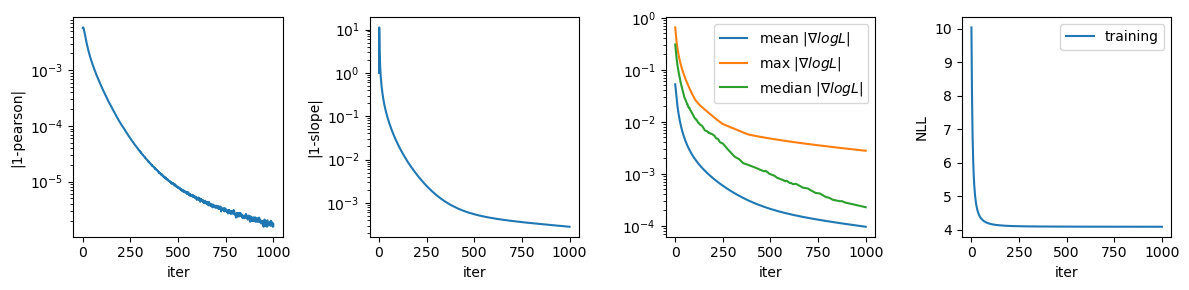

In [328]:
callbacks_indep[0].plot();

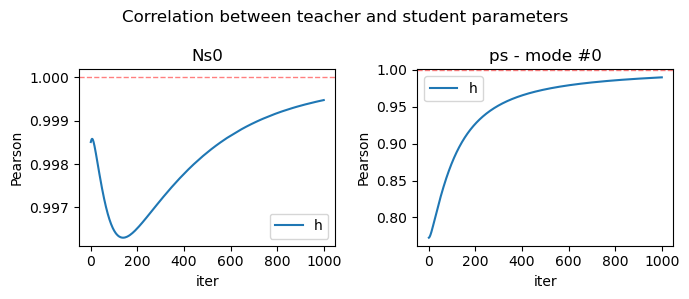

In [330]:
callbacks_indep[1].plot(figsize=(7,3));

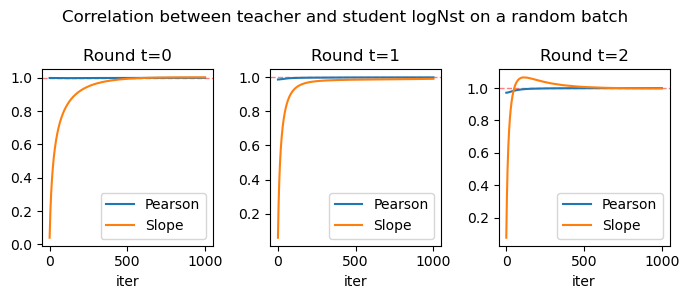

In [331]:
callbacks_indep[1].plot_pearson_energies(figsize=(7,3));

0.9994757771492004

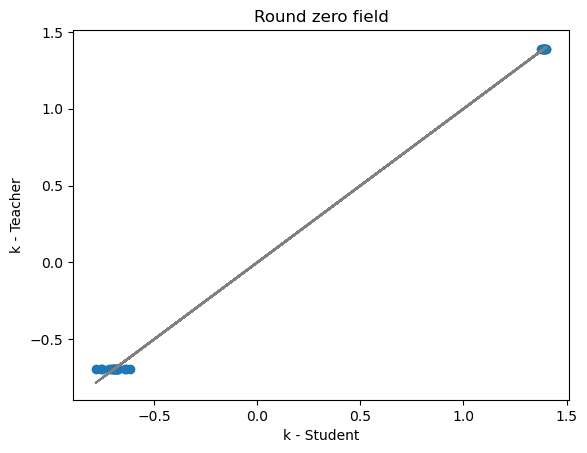

In [332]:
X = model_indep.round_zero.set_zerosum_gauge().h.detach().reshape(-1)
Y = model_teacher.round_zero.set_zerosum_gauge().h.detach().reshape(-1)
plt.scatter(X, Y)
plt.plot(X, X, color='gray')
plt.xlabel('k - Student'); plt.ylabel('k - Teacher')
plt.title('Round zero field')
utils.compute_pearson(X, Y)

0.9899113774299622

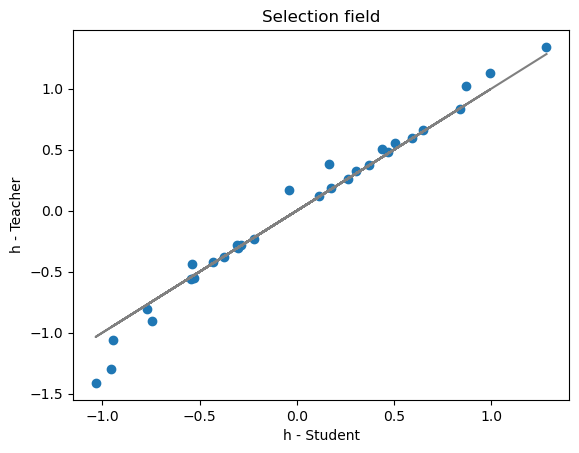

In [333]:
X = model_indep.selection.modes[0].set_zerosum_gauge().h.detach().reshape(-1)
Y = model_teacher.selection.modes[0].set_zerosum_gauge().h.detach().reshape(-1)
plt.scatter(X, Y)
plt.plot(X, X, color='gray')
plt.xlabel('h - Student'); plt.ylabel('h - Teacher')
plt.title('Selection field')
utils.compute_pearson(X, Y)

In [197]:
k = torch.zeros(L, q, dtype=dtype)
h = torch.zeros(L, q, dtype=dtype)

Ns0 = energy_models.IndepSites(k)
ps = selex_distribution.MultiModeDistribution(energy_models.IndepSites(h), normalized=False)
model = selex_distribution.MultiRoundDistribution(Ns0, ps, tr, selected_modes, learn_selection_strength=False)

In [198]:
batch_size = 10**4
data_loaders = [data_loading.SelexRoundDataLoader(sequences_oh[id], batch_size=batch_size, device=torch.device('cpu')) 
                for id in range(n_rounds)]

In [199]:
n_chains = 10**4
chains = training.init_chains(n_rounds, n_chains, L, q, dtype=dtype)
log_weights = torch.zeros(n_rounds, n_chains, dtype=dtype)

In [200]:
callbacks = [callback.ConvergenceMetricsCallback(), callback.TeacherStudentCallback(model_teacher)]

In [201]:
n_sweeps = 10
lr = 0.1
max_epochs = 100

training.train(model, data_loaders, total_reads, chains, n_sweeps, max_epochs,
               lr=lr, callbacks=callbacks, log_weights=log_weights)

 0.00%[                                 ] Epoch: 0/100 [00:00<?, ?it/s]

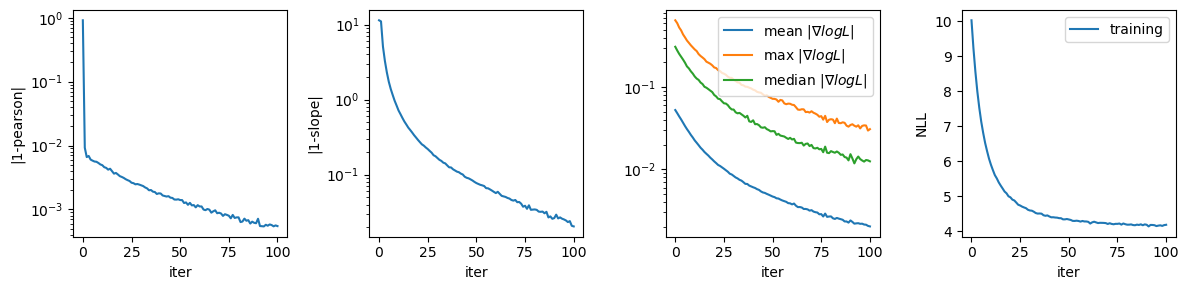

In [205]:
callbacks[0].plot();

INDEP SITES


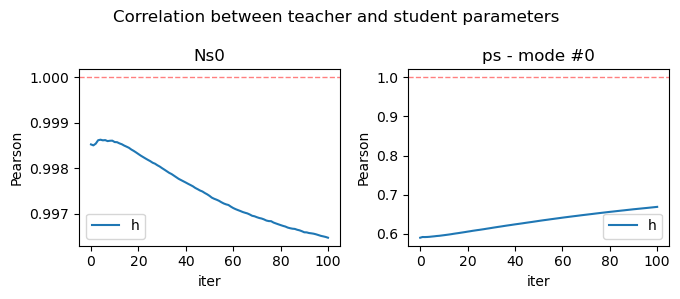

In [206]:
callbacks[1].plot(figsize=(7,3))
print('INDEP SITES')

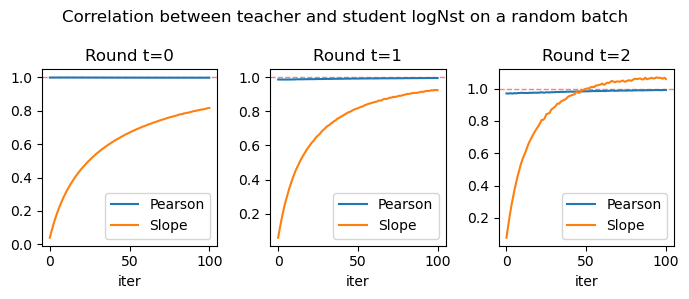

In [207]:
callbacks[1].plot_pearson_energies(figsize=(7,3));

0.9964732527732849

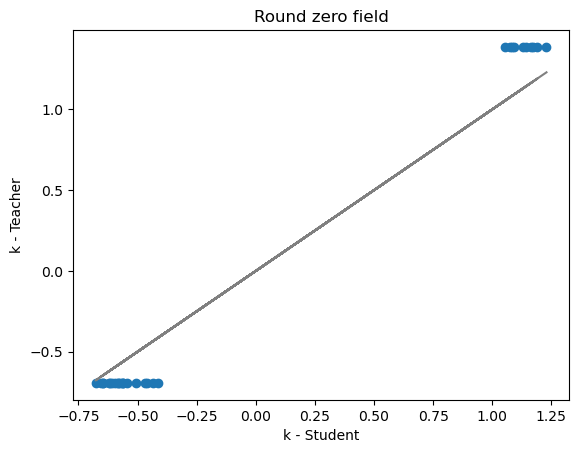

In [210]:
X = model.round_zero.set_zerosum_gauge().h.detach().reshape(-1)
Y = model_teacher.round_zero.set_zerosum_gauge().h.detach().reshape(-1)
plt.scatter(X, Y)
plt.plot(X, X, color='gray')
plt.xlabel('k - Student'); plt.ylabel('k - Teacher')
plt.title('Round zero field')
utils.compute_pearson(X, Y)

0.8737379908561707

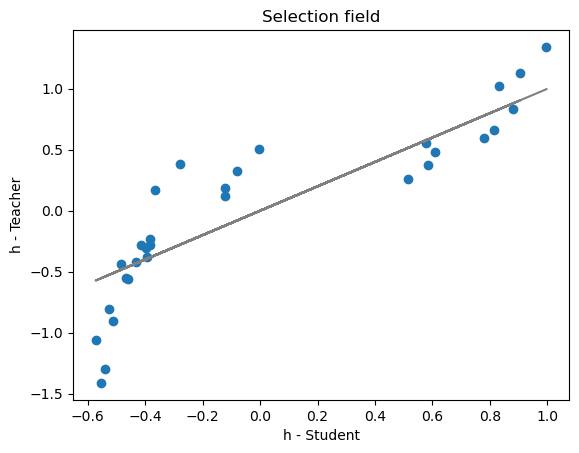

In [211]:
X = model.selection.modes[0].set_zerosum_gauge().h.detach().reshape(-1)
Y = model_teacher.selection.modes[0].set_zerosum_gauge().h.detach().reshape(-1)
plt.scatter(X, Y)
plt.plot(X, X, color='gray')
plt.xlabel('h - Student'); plt.ylabel('h - Teacher')
plt.title('Selection field')
utils.compute_pearson(X, Y)

## Compute energies for sequences far away from the wildtype

In [533]:
wt_far_oh = one_hot(torch.randint(q, (L,)))
k_far = utils.field_from_wildtype(wt_far_oh, mutation_rate)
hamming(wt_oh, wt_far_oh)

tensor(6, dtype=torch.int32)

In [534]:
X_far = sampling.sample_indep_sites(k_far, n_samples=chains_teacher[0].size(0))
X_close = sequences_oh[0]

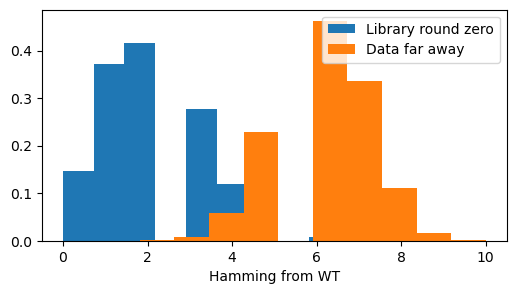

In [535]:
fig, ax = plt.subplots(figsize=(6,3))
ax.hist(hamming(wt_oh, X_close), label='Library round zero', bins=L+1, density=True)
ax.hist(hamming(wt_oh, X_far), label='Data far away', bins=L+1, density=True)
ax.set_xlabel('Hamming from WT')
ax.legend();

INDEP SITES


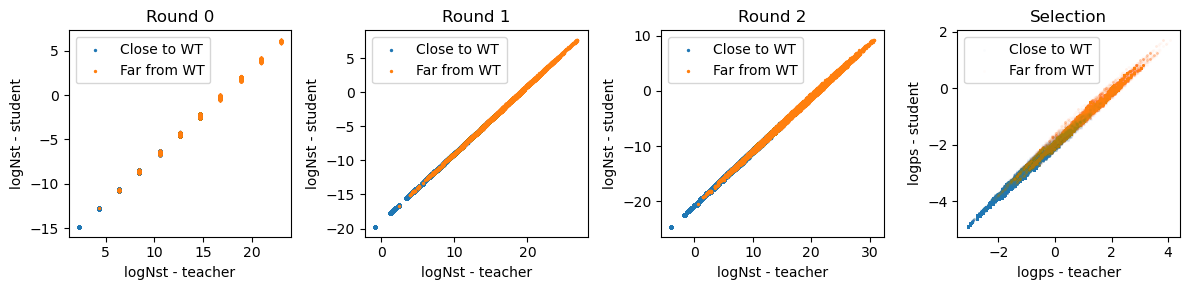

In [536]:
fig, axes = plt.subplots(1, n_rounds+1, figsize=(12, 3))

alpha = 0.01

for t in range(n_rounds):
    ax = axes[t]
    en_teacher = model_teacher.compute_energy_up_to_round(X_close, t).detach()
    en_student = model.compute_energy_up_to_round(X_close, t).detach()
    ax.scatter(en_teacher, en_student, label='Close to WT', s=2)
    en_teacher = model_teacher.compute_energy_up_to_round(X_far, t).detach()
    en_student = model.compute_energy_up_to_round(X_far, t).detach()
    ax.scatter(en_teacher, en_student, label='Far from WT', s=2)
    ax.legend()
    ax.set_xlabel('logNst - teacher'); ax.set_ylabel('logNst - student')
    ax.set_title(f'Round {t}')
    
ax = axes[-1]
en_teacher = model_teacher.selection_energy_at_round(X_close, 1).detach()
en_student = model.selection_energy_at_round(X_close, 1).detach()
ax.scatter(en_teacher, en_student, label='Close to WT', s=2, alpha=alpha)
en_teacher = model_teacher.selection_energy_at_round(X_far, 1).detach()
en_student = model.selection_energy_at_round(X_far, 1).detach()
ax.scatter(en_teacher, en_student, label='Far from WT', s=2, alpha=alpha)
ax.legend()
ax.set_xlabel('logps - teacher'); ax.set_ylabel('logps - student')
ax.set_title(f'Selection')
fig.tight_layout()

print('INDEP SITES')

## Predict empirical enrichments

In [537]:
sequences_unique_all_oh, counts_unique, enrichments = utils.unique_sequences_counts_enrichments(sequences_oh)

Extracting unique sequences and counts at each round...
Merging sequences from all rounds in a single container...
Assigning counts at each round to unique sequences...
	Starting round 0...
	Starting round 1...
	Starting round 2...
Calculating enrichments...
Finished


In [538]:
import importlib
importlib.reload(utils)

<module 'utils' from '/home/scrotti/Aptamer2025py/utils.py'>

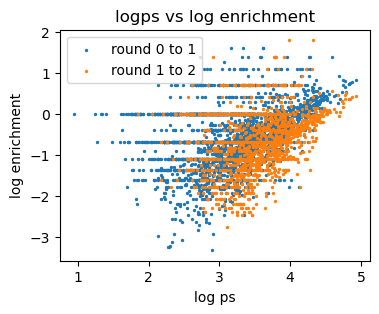

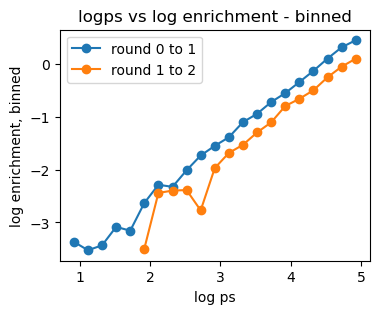

In [539]:
utils.binned_logenrichments(model, sequences_unique_all_oh, enrichments, counts_unique, n_bins = 25, plot=True, thresh=0.0);

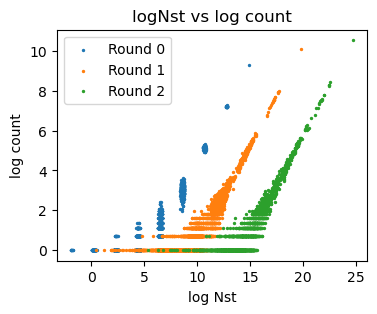

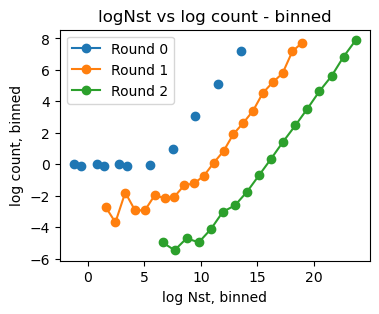

In [540]:
(logNst_unique, bins_Nst, logNst_binned, logcounts_binned_logNst, _, _,
 fig1, fig2) = utils.binned_logcounts(model, sequences_unique_all_oh, counts_unique, n_bins = 25, plot=True, thresh=0.0);

In [541]:
shift = - (reg.intercept_ / reg.coef_[0])
shift

np.float32(14.071438)

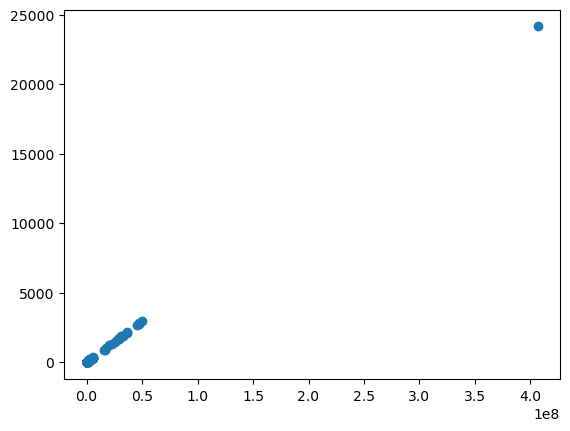

In [542]:
t = 1
plt.scatter(torch.exp(logNst_unique[t]), counts_unique[t])

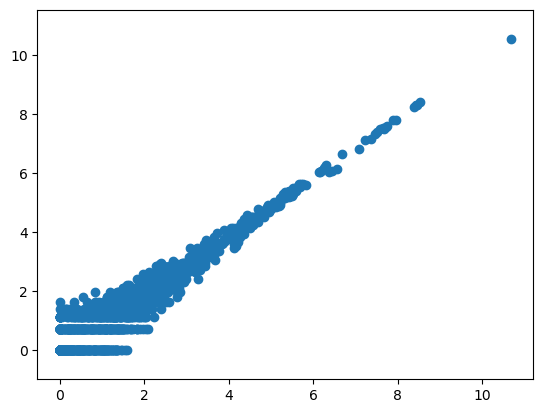

In [546]:
count_thresh = 15

t = 2
idx = counts_unique[t] > count_thresh
x = logNst_unique[t][idx]
y = torch.log(counts_unique[t][idx])
reg = sklearn.linear_model.LinearRegression()
X = x[:,None]
reg.fit(X, y)
yhat = reg.predict(logNst_unique[t][:,None])

fig, ax = plt.subplots()
shift = - (reg.intercept_ / reg.coef_[0])
ax.scatter(torch.max(torch.tensor([0]), logNst_unique[t] - shift), torch.log(counts_unique[t]))
reg2 = sklearn.linear_model.LinearRegression()

# ax.plot(logNst_unique[t] - shift, yhat, color='red')
ax.set_ylim((-1, y.max()+1));

(array([  17.,   69.,  351., 1271., 2429., 2433.,  946.,  229.,   46.,
           5.]),
 array([-1.92609751,  0.74133098,  3.40875959,  6.07618761,  8.7436161 ,
        11.41104507, 14.07847214, 16.74590111, 19.41333008, 22.08075905,
        24.74818802]),
 <BarContainer object of 10 artists>)

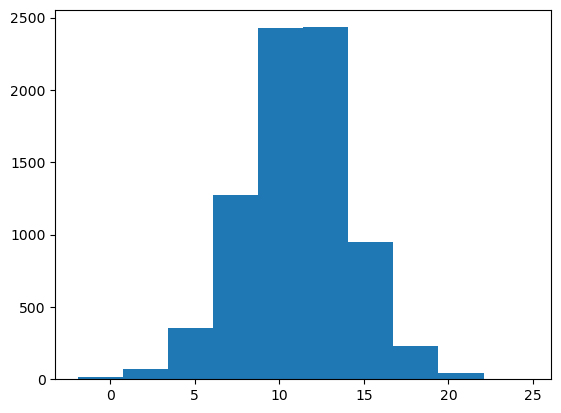

In [544]:
plt.hist(logNst_unique[t])